In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())        
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_8 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_9 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_17 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7513 - acc: 0.4909
Epoch 00001: val_loss improved from inf to 1.02341, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_9_conv_checkpoint/001-1.0234.hdf5
36805/36805 [==============================] - 177s 5ms/sample - loss: 1.7513 - acc: 0.4909 - val_loss: 1.0234 - val_acc: 0.6823
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8678 - acc: 0.7349
Epoch 00002: val_loss improved from 1.02341 to 0.74881, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_9_conv_checkpoint/002-0.7488.hdf5
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.8678 - acc: 0.7350 - val_loss: 0.7488 - val_acc: 0.7829
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6031 - acc: 0.8161
Epoch 00003: val_loss improved from 0.74881 to 0.3345

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0566 - acc: 0.9830
Epoch 00026: val_loss did not improve from 0.15576
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0567 - acc: 0.9829 - val_loss: 0.1974 - val_acc: 0.9457
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0615 - acc: 0.9807
Epoch 00027: val_loss did not improve from 0.15576
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0615 - acc: 0.9807 - val_loss: 0.1743 - val_acc: 0.9529
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9842
Epoch 00028: val_loss did not improve from 0.15576
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0513 - acc: 0.9842 - val_loss: 0.1666 - val_acc: 0.9541
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9868
Epoch 00029: val_loss did not improve from 0.15576
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9879
Epoch 00056: val_loss did not improve from 0.15576
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0384 - acc: 0.9879 - val_loss: 0.2224 - val_acc: 0.9513
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9933
Epoch 00057: val_loss did not improve from 0.15576
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.0220 - acc: 0.9932 - val_loss: 0.1975 - val_acc: 0.9536
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9942
Epoch 00058: val_loss did not improve from 0.15576
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.0177 - acc: 0.9942 - val_loss: 0.2100 - val_acc: 0.9520
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9960
Epoch 00059: val_loss did not improve from 0.15576
36805/36805 [========

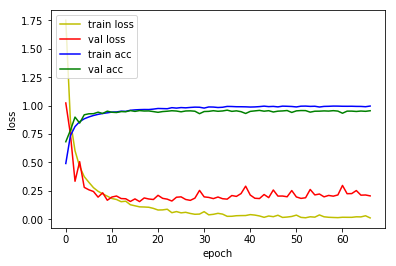

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.2176 - acc: 0.9418
Loss: 0.21759956766264213 Accuracy: 0.9418484



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_custom_conv_3_VGG_DO_BN_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (N

4815/4815 [==============================] - 7s 1ms/sample - loss: 1.2412 - acc: 0.6544
Loss: 1.241225696191857 Accuracy: 0.6544133

1D_CNN_custom_conv_3_VGG_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_110 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_26 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_111 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_27 (Activation)   (N

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.8658 - acc: 0.7502
Loss: 0.8657846676350135 Accuracy: 0.75015575

1D_CNN_custom_conv_3_VGG_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_132 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_30 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_133 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_31 (Activation)   

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.3030 - acc: 0.9136
Loss: 0.3030172028769338 Accuracy: 0.9136033

1D_CNN_custom_conv_3_VGG_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_162 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_163 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_35 (Activation)   (

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 12.3470 - acc: 0.1473
Epoch 00001: val_loss improved from inf to 13.84430, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_1_conv_checkpoint/001-13.8443.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 12.3475 - acc: 0.1473 - val_loss: 13.8443 - val_acc: 0.0978
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.9248 - acc: 0.1988
Epoch 00002: val_loss improved from 13.84430 to 12.08474, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_1_conv_checkpoint/002-12.0847.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 11.9252 - acc

36805/36805 [==============================] - 74s 2ms/sample - loss: 8.8300 - acc: 0.3925 - val_loss: 10.6827 - val_acc: 0.2234
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 8.3524 - acc: 0.4476
Epoch 00026: val_loss improved from 10.68275 to 10.41690, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_1_conv_checkpoint/026-10.4169.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 8.3521 - acc: 0.4476 - val_loss: 10.4169 - val_acc: 0.2371
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 8.2143 - acc: 0.4670
Epoch 00027: val_loss did not improve from 10.41690
36805/36805 [==============================] - 74s 2ms/sample - loss: 8.2140 - acc: 0.4670 - val_loss: 10.5809 - val_acc: 0.2402
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 8.1528 - acc: 0.4789
Epoch 00028: val_loss improved from 10.41690 to 10.34659, saving model to model/checkpoint/1D_CNN_custom_conv_3_V

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0900 - acc: 0.7979
Epoch 00052: val_loss did not improve from 7.11199
36805/36805 [==============================] - 74s 2ms/sample - loss: 3.0895 - acc: 0.7979 - val_loss: 7.3548 - val_acc: 0.3282
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0639 - acc: 0.8001
Epoch 00053: val_loss improved from 7.11199 to 6.83197, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_1_conv_checkpoint/053-6.8320.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 3.0648 - acc: 0.8001 - val_loss: 6.8320 - val_acc: 0.3447
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0396 - acc: 0.8030
Epoch 00054: val_loss did not improve from 6.83197
36805/36805 [==============================] - 74s 2ms/sample - loss: 3.0401 - acc: 0.8030 - val_loss: 7.1965 - val_acc: 0.3233
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1089 - acc: 0.9900
Epoch 00080: val_loss did not improve from 5.09194
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1088 - acc: 0.9900 - val_loss: 5.6296 - val_acc: 0.3443
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1046 - acc: 0.9914
Epoch 00081: val_loss did not improve from 5.09194
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1046 - acc: 0.9914 - val_loss: 5.3078 - val_acc: 0.3555
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1062 - acc: 0.9911
Epoch 00082: val_loss did not improve from 5.09194
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1062 - acc: 0.9911 - val_loss: 7.7287 - val_acc: 0.2888
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1088 - acc: 0.9889
Epoch 00083: val_loss did not improve from 5.09194
36805/36805 [===========

Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0893 - acc: 0.9934
Epoch 00110: val_loss did not improve from 5.09194
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.0893 - acc: 0.9934 - val_loss: 5.4629 - val_acc: 0.3783
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0900 - acc: 0.9930
Epoch 00111: val_loss did not improve from 5.09194
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.0900 - acc: 0.9930 - val_loss: 5.9533 - val_acc: 0.3392
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0907 - acc: 0.9930
Epoch 00112: val_loss did not improve from 5.09194
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.0907 - acc: 0.9930 - val_loss: 6.0972 - val_acc: 0.3573
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0910 - acc: 0.9927
Epoch 00113: val_loss did not improve from 5.09194
36805/36805 [=======

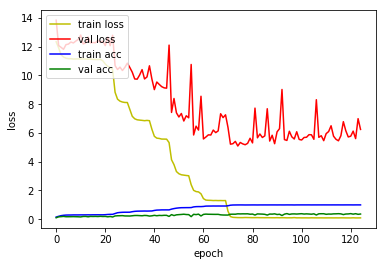

4815/4815 [==============================] - 3s 691us/sample - loss: 5.3634 - acc: 0.3448
Loss: 5.3634026266951675 Accuracy: 0.34475598

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3684 - acc: 0.2955
Epoch 00001: val_loss improved from inf to 2.96340, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_2_conv_checkpoint/001-2.9634.hdf5
36805/36805 [==============================] - 129s 4ms/sample - loss: 3.3683 - acc: 0.2955 - val_loss: 2.9634 - val_acc: 0.2765
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4488 - acc: 0.6035
Epoch 00002: val_loss did not improve from 2.96340
36805/36805 [==============================] - 127s 3ms/sample - loss: 1.4487 - acc: 0.6035 - val_loss: 3.2256 - val_acc: 0.3189
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8319 - acc: 0.7580
Epoch 00003: val_loss improved from 2.96340 to 2.91779, saving mode

36800/36805 [============================>.] - ETA: 0s - loss: 0.1126 - acc: 0.9748
Epoch 00029: val_loss did not improve from 2.91779
36805/36805 [==============================] - 126s 3ms/sample - loss: 0.1126 - acc: 0.9748 - val_loss: 5.4244 - val_acc: 0.4128
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1068 - acc: 0.9767
Epoch 00030: val_loss did not improve from 2.91779
36805/36805 [==============================] - 126s 3ms/sample - loss: 0.1068 - acc: 0.9767 - val_loss: 5.3487 - val_acc: 0.4018
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0904 - acc: 0.9811
Epoch 00031: val_loss did not improve from 2.91779
36805/36805 [==============================] - 127s 3ms/sample - loss: 0.0904 - acc: 0.9811 - val_loss: 5.8442 - val_acc: 0.3876
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0998 - acc: 0.9789
Epoch 00032: val_loss did not improve from 2.91779
36805/36805 [=====================

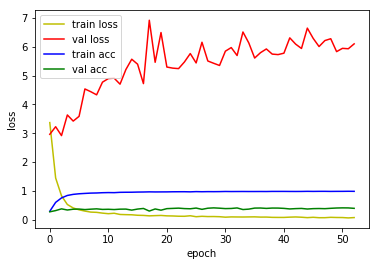

4815/4815 [==============================] - 6s 1ms/sample - loss: 3.0365 - acc: 0.3452
Loss: 3.036466135092366 Accuracy: 0.34517133

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4245 - acc: 0.3597
Epoch 00001: val_loss improved from inf to 1.90375, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_3_conv_checkpoint/001-1.9038.hdf5
36805/36805 [==============================] - 149s 4ms/sample - loss: 2.4243 - acc: 0.3597 - val_loss: 1.9038 - val_acc: 0.3993
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4344 - acc: 0.5692
Epoch 00002: val_loss improved from 1.90375 to 1.78106, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_3_conv_checkpoint/002-1.7811.hdf5
36805/36805 [==============================] - 145s 4ms/sample - loss: 1.4344 - acc: 0.5692 - val_loss: 1.7811 - val_acc: 0.4985
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0955 - acc: 0.9733
Epoch 00029: val_loss did not improve from 1.59943
36805/36805 [==============================] - 145s 4ms/sample - loss: 0.0955 - acc: 0.9733 - val_loss: 2.4986 - val_acc: 0.5847
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0926 - acc: 0.9732
Epoch 00030: val_loss did not improve from 1.59943
36805/36805 [==============================] - 145s 4ms/sample - loss: 0.0926 - acc: 0.9732 - val_loss: 2.6435 - val_acc: 0.5737
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0943 - acc: 0.9736
Epoch 00031: val_loss did not improve from 1.59943
36805/36805 [==============================] - 144s 4ms/sample - loss: 0.0943 - acc: 0.9736 - val_loss: 2.5785 - val_acc: 0.5865
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0888 - acc: 0.9749
Epoch 00032: val_loss did not improve from 1.59943
36805/36805 [========

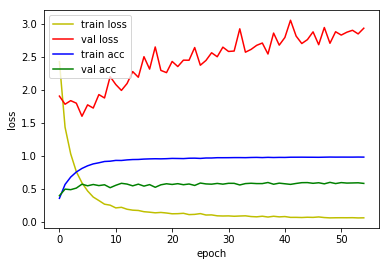

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.7968 - acc: 0.5221
Loss: 1.7968388077625976 Accuracy: 0.5221184

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2810 - acc: 0.3600
Epoch 00001: val_loss improved from inf to 1.93974, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_4_conv_checkpoint/001-1.9397.hdf5
36805/36805 [==============================] - 159s 4ms/sample - loss: 2.2811 - acc: 0.3600 - val_loss: 1.9397 - val_acc: 0.4002
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5138 - acc: 0.5376
Epoch 00002: val_loss improved from 1.93974 to 1.30155, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_4_conv_checkpoint/002-1.3016.hdf5
36805/36805 [==============================] - 150s 4ms/sample - loss: 1.5139 - acc: 0.5376 - val_loss: 1.3016 - val_acc: 0.5989
Epoch 3/500
36800/36805 [============================>.] - ETA:

36800/36805 [============================>.] - ETA: 0s - loss: 0.1859 - acc: 0.9410
Epoch 00028: val_loss did not improve from 1.10923
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.1860 - acc: 0.9410 - val_loss: 1.2163 - val_acc: 0.7174
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1774 - acc: 0.9442
Epoch 00029: val_loss did not improve from 1.10923
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.1774 - acc: 0.9441 - val_loss: 1.2924 - val_acc: 0.7102
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1702 - acc: 0.9470
Epoch 00030: val_loss did not improve from 1.10923
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.1703 - acc: 0.9469 - val_loss: 1.3021 - val_acc: 0.6993
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1690 - acc: 0.9460
Epoch 00031: val_loss did not improve from 1.10923
36805/36805 [=====================

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0911 - acc: 0.9724
Epoch 00058: val_loss did not improve from 1.10923
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.0911 - acc: 0.9723 - val_loss: 1.3801 - val_acc: 0.7314
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0907 - acc: 0.9726
Epoch 00059: val_loss did not improve from 1.10923
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.0908 - acc: 0.9726 - val_loss: 1.5098 - val_acc: 0.7223
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0906 - acc: 0.9733
Epoch 00060: val_loss did not improve from 1.10923
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.0909 - acc: 0.9732 - val_loss: 1.3999 - val_acc: 0.7321

1D_CNN_custom_conv_3_VGG_DO_BN_4_conv Model


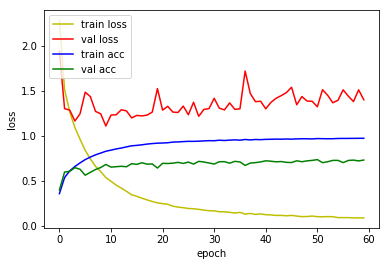

4815/4815 [==============================] - 7s 1ms/sample - loss: 1.2333 - acc: 0.6496
Loss: 1.2332667967240758 Accuracy: 0.64963657

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0789 - acc: 0.4033
Epoch 00001: val_loss improved from inf to 1.41285, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_5_conv_checkpoint/001-1.4128.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 2.0787 - acc: 0.4034 - val_loss: 1.4128 - val_acc: 0.5390
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4378 - acc: 0.5689
Epoch 00002: val_loss improved from 1.41285 to 1.14488, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_5_conv_checkpoint/002-1.1449.hdf5
36805/36805 [==============================] - 156s 4ms/sample - loss: 1.4384 - acc: 0.5688 - val_loss: 1.1449 - val_acc: 0.6506
Epoch 3/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 0.2023 - acc: 0.9369
Epoch 00026: val_loss did not improve from 0.89820
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.2023 - acc: 0.9369 - val_loss: 0.9607 - val_acc: 0.7619
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1948 - acc: 0.9382
Epoch 00027: val_loss did not improve from 0.89820
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.1950 - acc: 0.9382 - val_loss: 1.0767 - val_acc: 0.7463
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1922 - acc: 0.9383
Epoch 00028: val_loss did not improve from 0.89820
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.1923 - acc: 0.9383 - val_loss: 1.0245 - val_acc: 0.7573
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1833 - acc: 0.9422
Epoch 00029: val_loss did not improve from 0.89820
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9736
Epoch 00056: val_loss did not improve from 0.89820
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.0891 - acc: 0.9736 - val_loss: 1.0939 - val_acc: 0.7764
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0898 - acc: 0.9727
Epoch 00057: val_loss did not improve from 0.89820
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.0898 - acc: 0.9727 - val_loss: 1.1722 - val_acc: 0.7682
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0983 - acc: 0.9695
Epoch 00058: val_loss did not improve from 0.89820
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.0983 - acc: 0.9695 - val_loss: 1.1316 - val_acc: 0.7701
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0884 - acc: 0.9724
Epoch 00059: val_loss did not improve from 0.89820
36805/36805 [========

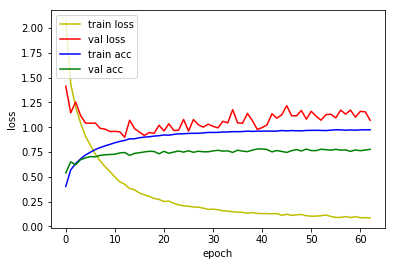

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.9801 - acc: 0.7254
Loss: 0.9800655689194938 Accuracy: 0.72544134

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2257 - acc: 0.3634
Epoch 00001: val_loss improved from inf to 1.58461, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_6_conv_checkpoint/001-1.5846.hdf5
36805/36805 [==============================] - 179s 5ms/sample - loss: 2.2254 - acc: 0.3635 - val_loss: 1.5846 - val_acc: 0.4694
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5039 - acc: 0.5449
Epoch 00002: val_loss improved from 1.58461 to 1.10763, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_6_conv_checkpoint/002-1.1076.hdf5
36805/36805 [==============================] - 159s 4ms/sample - loss: 1.5040 - acc: 0.5448 - val_loss: 1.1076 - val_acc: 0.6590
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3287 - acc: 0.8974
Epoch 00027: val_loss did not improve from 0.73750
36805/36805 [==============================] - 159s 4ms/sample - loss: 0.3287 - acc: 0.8974 - val_loss: 0.9861 - val_acc: 0.7393
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3164 - acc: 0.8987
Epoch 00028: val_loss did not improve from 0.73750
36805/36805 [==============================] - 159s 4ms/sample - loss: 0.3164 - acc: 0.8987 - val_loss: 0.8239 - val_acc: 0.7713
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3075 - acc: 0.9028
Epoch 00029: val_loss did not improve from 0.73750
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.3075 - acc: 0.9028 - val_loss: 0.8586 - val_acc: 0.7622
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2924 - acc: 0.9082
Epoch 00030: val_loss did not improve from 0.73750
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1365 - acc: 0.9568
Epoch 00057: val_loss did not improve from 0.73750
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.1365 - acc: 0.9568 - val_loss: 0.9192 - val_acc: 0.7871
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1442 - acc: 0.9543
Epoch 00058: val_loss did not improve from 0.73750
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.1443 - acc: 0.9543 - val_loss: 0.8835 - val_acc: 0.7971
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1530 - acc: 0.9521
Epoch 00059: val_loss did not improve from 0.73750
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.1530 - acc: 0.9522 - val_loss: 0.9350 - val_acc: 0.7820
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1345 - acc: 0.9580
Epoch 00060: val_loss did not improve from 0.73750
36805/36805 [========

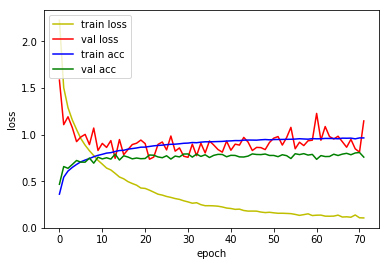

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.8075 - acc: 0.7568
Loss: 0.8075062907373423 Accuracy: 0.75680166

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3304 - acc: 0.3326
Epoch 00001: val_loss improved from inf to 1.63511, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_7_conv_checkpoint/001-1.6351.hdf5
36805/36805 [==============================] - 188s 5ms/sample - loss: 2.3305 - acc: 0.3326 - val_loss: 1.6351 - val_acc: 0.4698
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5555 - acc: 0.5203
Epoch 00002: val_loss improved from 1.63511 to 1.19226, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_7_conv_checkpoint/002-1.1923.hdf5
36805/36805 [==============================] - 160s 4ms/sample - loss: 1.5555 - acc: 0.5203 - val_loss: 1.1923 - val_acc: 0.6280
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3324 - acc: 0.8986
Epoch 00027: val_loss improved from 0.63239 to 0.59895, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_7_conv_checkpoint/027-0.5990.hdf5
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.3325 - acc: 0.8985 - val_loss: 0.5990 - val_acc: 0.8409
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3206 - acc: 0.9021
Epoch 00028: val_loss did not improve from 0.59895
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.3207 - acc: 0.9021 - val_loss: 0.6097 - val_acc: 0.8318
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2997 - acc: 0.9083
Epoch 00029: val_loss did not improve from 0.59895
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.2998 - acc: 0.9082 - val_loss: 0.5994 - val_acc: 0.8388
Epoch 30/500
36800/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.1093 - acc: 0.9661
Epoch 00056: val_loss did not improve from 0.59895
36805/36805 [==============================] - 159s 4ms/sample - loss: 0.1093 - acc: 0.9661 - val_loss: 0.7172 - val_acc: 0.8458
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1100 - acc: 0.9668
Epoch 00057: val_loss did not improve from 0.59895
36805/36805 [==============================] - 159s 4ms/sample - loss: 0.1101 - acc: 0.9668 - val_loss: 0.7723 - val_acc: 0.8346
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1132 - acc: 0.9663
Epoch 00058: val_loss did not improve from 0.59895
36805/36805 [==============================] - 160s 4ms/sample - loss: 0.1132 - acc: 0.9663 - val_loss: 0.7085 - val_acc: 0.8404
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1069 - acc: 0.9660
Epoch 00059: val_loss did not improve from 0.59895
36805/36805 [=====================

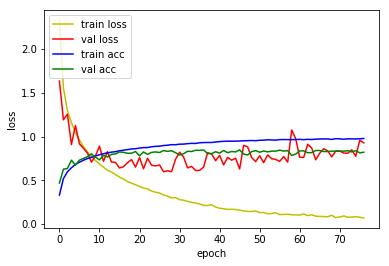

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.6624 - acc: 0.8098
Loss: 0.6623675947124961 Accuracy: 0.80976117

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2558 - acc: 0.3349
Epoch 00001: val_loss improved from inf to 1.50435, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_8_conv_checkpoint/001-1.5044.hdf5
36805/36805 [==============================] - 206s 6ms/sample - loss: 2.2558 - acc: 0.3349 - val_loss: 1.5044 - val_acc: 0.5495
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4426 - acc: 0.5476
Epoch 00002: val_loss improved from 1.50435 to 0.93276, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_8_conv_checkpoint/002-0.9328.hdf5
36805/36805 [==============================] - 162s 4ms/sample - loss: 1.4427 - acc: 0.5476 - val_loss: 0.9328 - val_acc: 0.7144
Epoch 3/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 0.1682 - acc: 0.9485
Epoch 00025: val_loss did not improve from 0.26640
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.1683 - acc: 0.9485 - val_loss: 0.2756 - val_acc: 0.9215
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1620 - acc: 0.9495
Epoch 00026: val_loss improved from 0.26640 to 0.26416, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_8_conv_checkpoint/026-0.2642.hdf5
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.1619 - acc: 0.9495 - val_loss: 0.2642 - val_acc: 0.9290
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1492 - acc: 0.9544
Epoch 00027: val_loss did not improve from 0.26416
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.1492 - acc: 0.9544 - val_loss: 0.2801 - val_acc: 0.9208
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0661 - acc: 0.9795
Epoch 00054: val_loss did not improve from 0.25418
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.0661 - acc: 0.9795 - val_loss: 0.3265 - val_acc: 0.9271
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0500 - acc: 0.9849
Epoch 00055: val_loss did not improve from 0.25418
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.0500 - acc: 0.9849 - val_loss: 0.3324 - val_acc: 0.9236
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9868
Epoch 00056: val_loss did not improve from 0.25418
36805/36805 [==============================] - 161s 4ms/sample - loss: 0.0424 - acc: 0.9868 - val_loss: 0.4343 - val_acc: 0.9133
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0590 - acc: 0.9827
Epoch 00057: val_loss did not improve from 0.25418
36805/36805 [========

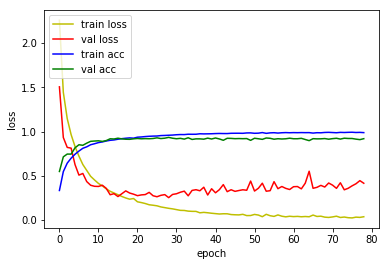

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.3440 - acc: 0.9043
Loss: 0.3440394027087052 Accuracy: 0.90425754

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6940 - acc: 0.5038
Epoch 00001: val_loss improved from inf to 1.07241, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_9_conv_checkpoint/001-1.0724.hdf5
36805/36805 [==============================] - 223s 6ms/sample - loss: 1.6938 - acc: 0.5038 - val_loss: 1.0724 - val_acc: 0.6685
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8171 - acc: 0.7521
Epoch 00002: val_loss improved from 1.07241 to 0.52664, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_9_conv_checkpoint/002-0.5266.hdf5
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.8170 - acc: 0.7521 - val_loss: 0.5266 - val_acc: 0.8430
Epoch 3/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 0.0620 - acc: 0.9812
Epoch 00025: val_loss improved from 0.15564 to 0.15096, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_9_conv_checkpoint/025-0.1510.hdf5
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0620 - acc: 0.9813 - val_loss: 0.1510 - val_acc: 0.9560
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9815
Epoch 00026: val_loss did not improve from 0.15096
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0587 - acc: 0.9815 - val_loss: 0.2056 - val_acc: 0.9499
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0554 - acc: 0.9834
Epoch 00027: val_loss did not improve from 0.15096
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0554 - acc: 0.9834 - val_loss: 0.1623 - val_acc: 0.9555
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9937
Epoch 00054: val_loss did not improve from 0.15096
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.0196 - acc: 0.9937 - val_loss: 0.2488 - val_acc: 0.9499
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9944
Epoch 00055: val_loss did not improve from 0.15096
36805/36805 [==============================] - 166s 5ms/sample - loss: 0.0192 - acc: 0.9944 - val_loss: 0.2403 - val_acc: 0.9471
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9940
Epoch 00056: val_loss did not improve from 0.15096
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0199 - acc: 0.9940 - val_loss: 0.2741 - val_acc: 0.9383
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9921
Epoch 00057: val_loss did not improve from 0.15096
36805/36805 [=====================

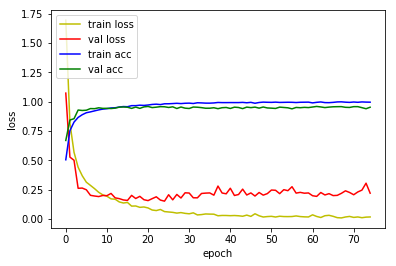

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2280 - acc: 0.9317
Loss: 0.22803634875381476 Accuracy: 0.93167186



In [9]:
base = '1D_CNN_custom_conv_3_VGG_DO_BN'

for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [10]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (N

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.2333 - acc: 0.6496
Loss: 1.2332667967240758 Accuracy: 0.64963657

1D_CNN_custom_conv_3_VGG_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_8 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_9 (Activation)    

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.8075 - acc: 0.7568
Loss: 0.8075062907373423 Accuracy: 0.75680166

1D_CNN_custom_conv_3_VGG_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_13 (Activation)   

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.3440 - acc: 0.9043
Loss: 0.3440394027087052 Accuracy: 0.90425754

1D_CNN_custom_conv_3_VGG_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_17 (Activation)   

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (N

4815/4815 [==============================] - 10s 2ms/sample - loss: 1.6296 - acc: 0.6804
Loss: 1.6296311777823935 Accuracy: 0.68037385

1D_CNN_custom_conv_3_VGG_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_8 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_9 (Activation)   

4815/4815 [==============================] - 10s 2ms/sample - loss: 1.2641 - acc: 0.7358
Loss: 1.2641129458123896 Accuracy: 0.73582554

1D_CNN_custom_conv_3_VGG_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_13 (Activation)  

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.4613 - acc: 0.9026
Loss: 0.4612602666531025 Accuracy: 0.90259606

1D_CNN_custom_conv_3_VGG_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_17 (Activation)  